In [143]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, ODEModel, LearnTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st
importlib.reload(ODEModel)
from ODEModel import ODEfunc, coordMLP, FfjordModel
importlib.reload(LearnTraj);
from LearnTraj import learn_trajectory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

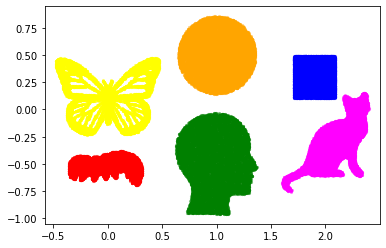

In [157]:
im1 = ImageDataset('butterfly.jpg'); 
im1b = ImageDataset('butterflyfilled.jpg'); 
im2 = ImageDataset('caterpillar.png', noise_std = .005); 
im3 = ImageDataset('circle.jpeg'); 
im4 = ImageDataset('baldhead.jpeg'); 
im5 = ImageDataset('square.png'); 
im6 = ImageDataset('cat1.png'); 

n_inner = 10000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

0 lr 0.0001
batch 0 loss tensor(2., grad_fn=<AddBackward0>)


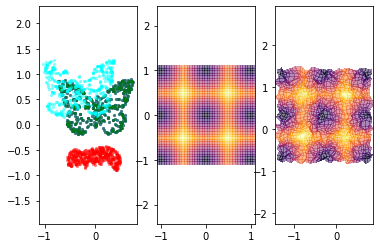

time elapsed 1.4684712886810303 total time 1.4684712886810303
batch number 0 out of 451
savetime 0.0
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 n_subsample 915
lr 0.0001
batch 150 loss tensor(0.0190, grad_fn=<AddBackward0>)


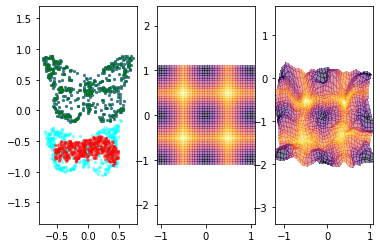

time elapsed 183.325012922287 total time 184.79846668243408
batch number 150 out of 451
savetime 1.6626129150390625
151 152 153 154 155 156 

In [ ]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
sigmac = 10; n_freq = 256;
model = coordMLP(sigmac = sigmac, n_freq = n_freq).to(device); 
bmodel = coordMLP(sigmac = sigmac, n_freq = n_freq).to(device); 
# model.load_state('models/state_end.tar');
# %prun 
model, losses, separate_losses, lrs, n_subs = learn_trajectory(keyframes, n_iters = 451,n_subsample=500, model=model, bmodel=bmodel, save=True)

In [154]:
# st.gpu_usage()
# z_target.shape
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));

# torch.cuda.empty_cache()
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));
# model = FfjordModel().to(device); model.load_state('models/state_start.tar'); # print(next(model.parameters()).is_cuda)
# my_loss = 'sinkhorn_large_reg';
myln = 'fit_0';
subsample_inds = torch.randperm(keyframes.shape[1])[:4000];
st.save_trajectory(model,keyframes[:,subsample_inds,:],myln, savedir='imgs', nsteps=20, memory=0.01, n=500,dpiv=400)
st.gpu_usage()
st.trajectory_to_video(myln, savedir='imgs', mp4_fn='transform.mp4')

# integration_times = torch.linspace(0,z_target.shape[0]-1,2).to(device);
# model(z_target[1,:,:], integration_times)


Allocated: 0.0 GB  Reserved: 0.0 GB


<Figure size 432x288 with 0 Axes>

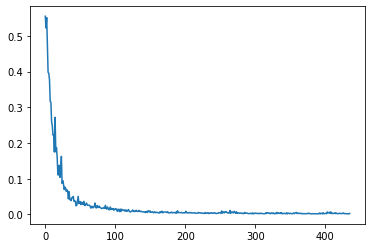

In [155]:
start=15;end=20000;
plt.plot(losses[start:end]); 
# plt.plot(separate_losses[0,start:end],'g'); 
# plt.plot(separate_losses[1,start:end],'r'); 
# plt.plot(separate_losses[2,start:end]); 
# plt.plot(separate_losses[3,start:end]*.01,'r'); 
# plt.plot(separate_losses[4,start:end]*10,'b'); 
# plt.plot(separate_losses[5,start:end]); 
# plt.plot(separate_losses[6,start:end]);
plt.savefig(os.path.join('./', f"viz_loss.jpg"),dpi=400); 

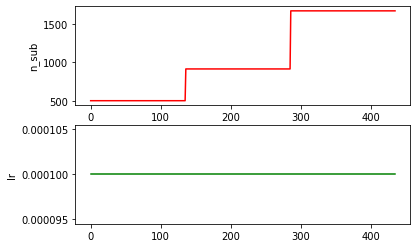

In [156]:
(fig,(ax1,ax2))=plt.subplots(2,1)
ax1.plot(n_subs[start:end],'r'); ax1.set_ylabel('n_sub')
ax2.plot(lrs[start:end],'g'); ax2.set_ylabel('lr') 
plt.savefig(os.path.join('./', f"viz_stat.jpg"),dpi=400); 

In [ ]:
torch.cuda.empty_cache() 
st.gpu_usage()

In [ ]:
name = 'cat1.png'
# # name = 'butterfly.jpg'
img = cv.imread(name, cv.IMREAD_UNCHANGED);
imggray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape)
print(imggray.shape)

edges = cv.Canny(img,50,200)
# print(img.min(),img.max())
# print(edges.min(),edges.max())
plt.imshow(imggray);plt.show()
plt.imshow(img);plt.show()
plt.imshow(edges);plt.show()
# i2 = img.copy()

# img = cv.imread(name);
# img[img<.8*255]=0; 
# # img/=img.max()
# img=img.astype('float')
# img/=img.max()
# img.shape

print(img.min(),img.max())
print(imggray.min(),imggray.max())

In [ ]:
# test what weights are given to what frequencies in the first layer
for param in model.parameters():
    print(type(param.data), param.size())
    pdat = param.data;
    break;    
pmags = torch.norm(param.data,p=2,dim=0);
freqs = model.time_deriv_func.imap.B;
nf = freqs.shape[0];
nd = (pmags.shape[0]-2*nf)

fmags = torch.norm(freqs,p=2,dim=1);
xyfreqs = torch.cat([fmags, fmags],dim=0);
print(xyfreqs.size())

plt.plot(xyfreqs.cpu().numpy(), pmags[0:(nf*2)].cpu().numpy(),'.')
plt.plot(np.zeros(nd), pmags[(nf*2):].cpu().numpy(),'.')
plt.savefig(os.path.join('./', f"viz_freqs.jpg"),dpi=400); 
# # freqs
# # fmags

In [ ]:
## visualize ending sinkhorn costs as gradient on point clouds
# z_target = ImageDataset.normalize_samples(torch.stack((dat1,dat4)).to(device));
T = z_target.shape[0];

z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=False);
z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=True);
forward = z_t[T-1,:,:].cpu().detach().numpy();
backward = z_t_b[T-1,:,:].cpu().detach().numpy();

my_loss_f = SamplesLoss("sinkhorn", p=2, blur=0.01);
loss_f = my_loss_f(z_target[T-1,:,:], z_t[T-1,:,:])
loss_b = my_loss_f(z_target[0,:,:], z_t_b[T-1,:,:])

graddirs_f = torch.autograd.grad(loss_f, z_t)[0][T-1,:,:]
graddirs_b = torch.autograd.grad(loss_b, z_t_b)[0][T-1,:,:]

pos_f = z_t.cpu().detach().numpy()
pos_b = z_t_b.cpu().detach().numpy()
dirs_f = graddirs_f.cpu().detach().numpy()
dirs_b = graddirs_b.cpu().detach().numpy()

import os
plt.axis('equal')
plt.scatter(pos_b[0,:,0], pos_b[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(forward[:,0], forward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_f[T-1,:,0], pos_f[T-1,:,1], dirs_f[:,0], dirs_f[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_backward.jpg"),dpi=400); plt.clf()

plt.axis('equal')
plt.scatter(pos_f[0,:,0], pos_f[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(backward[:,0], backward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_b[T-1,:,0], pos_b[T-1,:,1], dirs_b[:,0], dirs_b[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_forward.jpg"),dpi=400); 


In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
losses